In [52]:
from monai.transforms import LoadImage, Spacing, NormalizeIntensity, Compose, Resize
import matplotlib.pyplot as plt
import numpy as np
import nrrd
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import concurrent.futures
import monai

file_path = '/home/hamad/pttut/NRRD Files/R01-005_CT.nrrd'
clinical_path = '/home/hamad/pttut/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv'
clinical_df = pd.read_csv(clinical_path, index_col=0)
patients_to_remove = ['R01-027', 'R01-029', 'R01-031', 'R01-163']
clinical_df = clinical_df.drop(patients_to_remove, axis=0)

train_df = '/home/hamad/pttut/project/data/csvs/train_data_resamples.csv'
test_df = '/home/hamad/pttut/project/data/csvs/test_data_resamples.csv'

train_df = pd.read_csv(train_df, index_col=-1)

# split train_df into train and val

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Histology'])


test_df = pd.read_csv(test_df, index_col=-1)

#print(train_df['Histology'].value_counts())

class ChestDataset(Dataset):
    def __init__(self, clinical_data):
        self.clinical_data = clinical_data
        self.dir_to_search = ['/home/hamad/pttut/NRRD Files/', '/home/hamad/pttut/Class 1/']
        self.nrrd_files = [ct for ct in os.listdir(self.dir_to_search[0]) if (ct.endswith('CT.nrrd') and ct.split('_')[0] in self.clinical_data.index)]
        self.lung_files = [ct for ct in os.listdir(self.dir_to_search[1]) if ct.split('.')[0] in self.clinical_data.index]
        self.targets = [self.clinical_data.loc[ct.split('_')[0]]['Histology'] for ct in self.nrrd_files] + [self.clinical_data.loc[ct.split('.')[0]]['Histology'] for ct in self.lung_files]
        self.unique_cases = set([ct.split('_')[0] for ct in self.nrrd_files]).union( set([ct.split('.')[0] for ct in self.lung_files]) )
        self.nrrd_files += self.lung_files
        
        self.transforms = Compose([ 
            NormalizeIntensity(nonzero=True, channel_wise=True),
            Resize((128, 128, 128))
        ])
                                
        
    def __len__(self):
        return len(self.nrrd_files)

    def load_file(self, file_path):
        image = sitk.ReadImage(file_path)
        original_spacing = image.GetSpacing()
        original_size = image.GetSize()
        new_spacing = (original_spacing[0], original_spacing[1], (original_spacing[2]*original_size[2])/128.0)
        new_size = (original_size[0], original_size[1], 128)
        resampled_image = sitk.Resample(image, new_size, sitk.Transform(), sitk.sitkLinear, image.GetOrigin(), new_spacing, image.GetDirection())
        image_array = sitk.GetArrayFromImage(resampled_image)
    
        return image_array
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        ct_file = self.nrrd_files[idx]
        if not 'LUNG' in ct_file:
            nrrd_dir = self.dir_to_search[0]
        else:
            nrrd_dir = self.dir_to_search[1]
        
        ct_file_path = os.path.join(nrrd_dir, ct_file)
        ct_array = self.load_file(ct_file_path)
        ct_array = ct_array.astype(np.float32)
        #ct_array = ct_array / 255.0
        ct_array = np.expand_dims(ct_array, axis=0)
        
        ct_tensor = torch.from_numpy(ct_array)
        
        ct_tensor = self.transforms(ct_tensor)
        
        target = self.targets[idx]
        # if target == 'Adenocarcinoma':
        #     target = 0
        # elif target == 'Squamous cell carcinoma':
        #     target = 1
        
        #ct_tensor = ct_tensor.permute(1, 0, 2, 3)
        return ct_tensor, torch.tensor(target, dtype=torch.long)

In [53]:
# test the above class
train_ds = ChestDataset(train_df)
val_ds = ChestDataset(valid_df)
test_ds = ChestDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, )
val_loader = DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=0, )
test_loader = DataLoader(test_ds, batch_size=2, shuffle=True, num_workers=0, )

----------
epoch 1/20
1/39, train_loss: 0.6110
2/39, train_loss: 0.6411
3/39, train_loss: 0.6112
4/39, train_loss: 0.6061
5/39, train_loss: 0.5935
6/39, train_loss: 0.5740
7/39, train_loss: 0.5225
8/39, train_loss: 0.5924
9/39, train_loss: 0.5468
10/39, train_loss: 0.4582
11/39, train_loss: 0.4294
12/39, train_loss: 0.4081
13/39, train_loss: 0.8032
14/39, train_loss: 0.7924
15/39, train_loss: 0.3956
16/39, train_loss: 0.8028
17/39, train_loss: 0.3533
18/39, train_loss: 0.5960
19/39, train_loss: 0.6203
20/39, train_loss: 0.3060
21/39, train_loss: 0.6485
22/39, train_loss: 0.3272
23/39, train_loss: 0.6206
24/39, train_loss: 0.2584
25/39, train_loss: 0.9988
26/39, train_loss: 0.5937
27/39, train_loss: 0.7468
28/39, train_loss: 0.2381
29/39, train_loss: 0.3263
30/39, train_loss: 0.6335
31/39, train_loss: 0.8156
32/39, train_loss: 0.6173
33/39, train_loss: 0.7998
34/39, train_loss: 0.8103
35/39, train_loss: 0.2214
36/39, train_loss: 0.6012
37/39, train_loss: 0.9736
38/39, train_loss: 0.2246

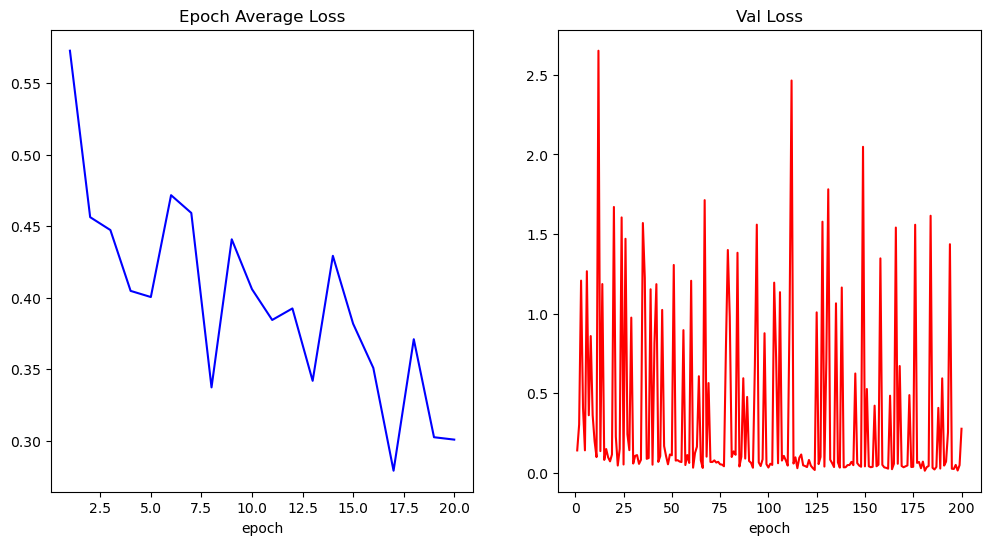

In [57]:
import torch
from monai.networks.nets import Densenet121
from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda:0')
model = Densenet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 20

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    #if (epoch + 1) % val_interval == 0:
    model.eval()

    num_correct = 0.0
    metric_count = 0
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        with torch.no_grad():
            val_outputs = model(val_images)
            value = torch.eq(val_outputs.argmax(dim=1), val_labels)
            metric_count += len(value)
            num_correct += value.sum().item()
            loss = loss_function(val_outputs, val_labels)
            val_loss_values.append(loss.item())

    metric = num_correct / metric_count
    metric_values.append(metric)

    if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
        print("saved new best metric model")

    print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
    print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
    writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()


# plot train loss vs validation loss curves

plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y, color='blue')
plt.subplot(1, 2, 2)
plt.title('Val Loss')
x = [i+1 for i in range(len(val_loss_values))]
y = val_loss_values
plt.xlabel('epoch')
plt.plot(x, y, color='red')
plt.show()








In [19]:
test_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=0, )
itera = iter(test_loader)
def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


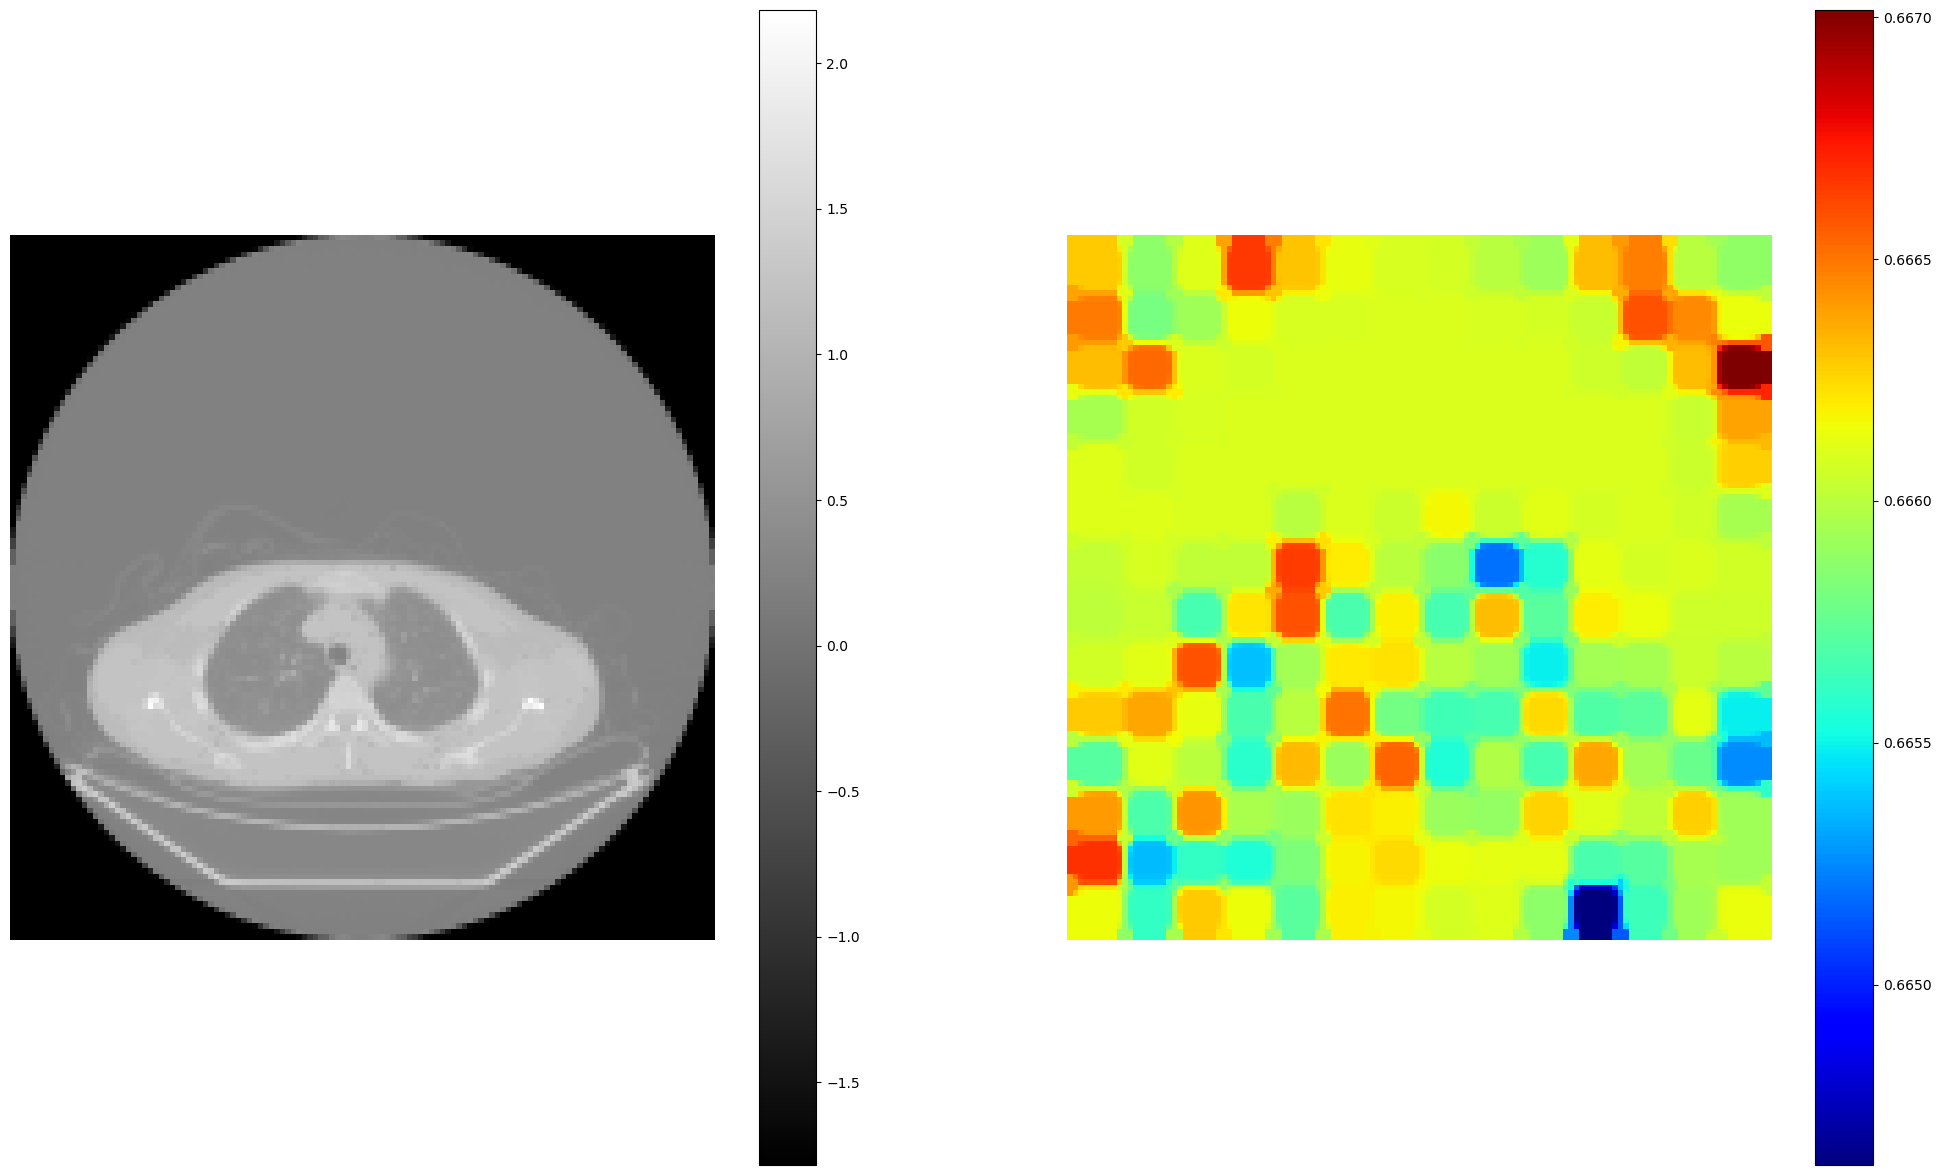

In [23]:
img, label = get_next_im()
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice =  90 #img.shape[2] // 2
occ_sens_b_box = [depth_slice - 1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

In [58]:
# evaluate on the test set

model.eval()

num_correct = 0.0
metric_count = 0

y_true = []
y_pred = []


for test_data in test_loader:
    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    with torch.no_grad():
        test_outputs = model(test_images)
        value = torch.eq(test_outputs.argmax(dim=1), test_labels)
        metric_count += len(value)
        num_correct += value.sum().item()
        y_true += test_labels.tolist()
        y_pred += test_outputs.argmax(dim=1).tolist()
        
metric = num_correct / metric_count

print(f"Test accuracy: {metric:.4f} ")


Test accuracy: 0.5319 


                         precision    recall  f1-score   support

         Adenocarcinoma       0.55      0.92      0.69        26
Squamous cell carcinoma       0.33      0.05      0.08        21

               accuracy                           0.53        47
              macro avg       0.44      0.49      0.38        47
           weighted avg       0.45      0.53      0.42        47



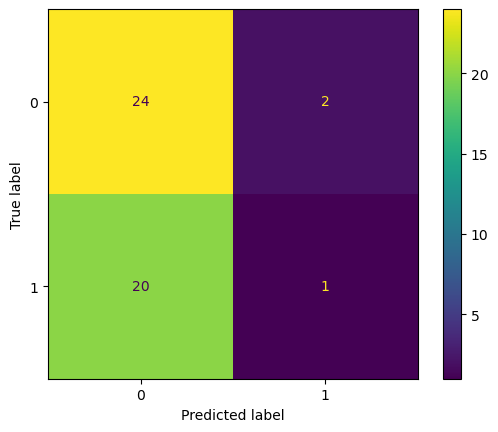

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import pandas as pd



ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

print(classification_report(y_true, y_pred, target_names=['Adenocarcinoma', 'Squamous cell carcinoma']))
        


Val accuracy: 0.9500 
                         precision    recall  f1-score   support

         Adenocarcinoma       0.92      1.00      0.96        11
Squamous cell carcinoma       1.00      0.89      0.94         9

               accuracy                           0.95        20
              macro avg       0.96      0.94      0.95        20
           weighted avg       0.95      0.95      0.95        20



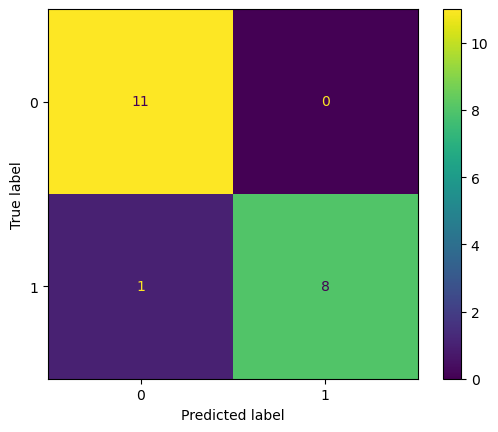

In [60]:
# evaluate on validation

model.eval()

num_correct = 0.0
metric_count = 0
y_true = []
y_pred = []
for test_data in val_loader:
    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    with torch.no_grad():
        test_outputs = model(test_images)
        value = torch.eq(test_outputs.argmax(dim=1), test_labels)
        metric_count += len(value)
        num_correct += value.sum().item()
        y_true += test_labels.tolist()
        y_pred += test_outputs.argmax(dim=1).tolist()
        
metric = num_correct / metric_count

print(f"Val accuracy: {metric:.4f} ")

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()
print(classification_report(y_true, y_pred, target_names=['Adenocarcinoma', 'Squamous cell carcinoma']))
        


Train accuracy: 0.9744 
                         precision    recall  f1-score   support

         Adenocarcinoma       0.95      1.00      0.98        42
Squamous cell carcinoma       1.00      0.94      0.97        36

               accuracy                           0.97        78
              macro avg       0.98      0.97      0.97        78
           weighted avg       0.98      0.97      0.97        78



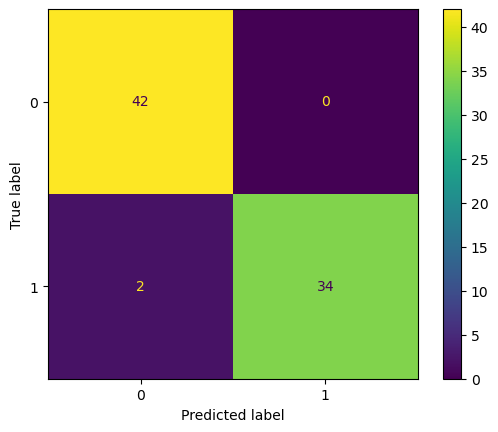

In [61]:
# evaluate on train

model.eval()

num_correct = 0.0
metric_count = 0

y_true = []
y_pred = []

for test_data in train_loader:
    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    with torch.no_grad():
        test_outputs = model(test_images)
        value = torch.eq(test_outputs.argmax(dim=1), test_labels)
        metric_count += len(value)
        num_correct += value.sum().item()
        
        y_true += test_labels.tolist()
        y_pred += test_outputs.argmax(dim=1).tolist()
        
        
        
metric = num_correct / metric_count

print(f"Train accuracy: {metric:.4f} ")

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

print(classification_report(y_true, y_pred, target_names=['Adenocarcinoma', 'Squamous cell carcinoma']))
        


